In [171]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy import wcs
from astropy.io import fits

In [172]:
def load_cat(filename):

    return pd.read_csv(filename, sep=r'\s+', skiprows=5, header=None, names=["ra", "dec",
            "flux", "flux_err"])

def plot_galaxy_B():
    
    plt.imshow(imageB[675:925, 325:825], cmap="magma", vmin=0.045, vmax=0.05)
    plt.colorbar()
    
def plot_galaxy_V():
    
    plt.imshow(imageV[575:825, 325:825], cmap="magma", vmin=0.09,vmax=0.105)
    plt.colorbar()

In [173]:
hdulB = fits.open("data/coadd.fits")
hduB = hdulB[0]
imageB = hduB.data.T

In [174]:
hdulV = fits.open("data/coadd_V.fits")
hduV = hdulV[0]
imageV = hduV.data.T

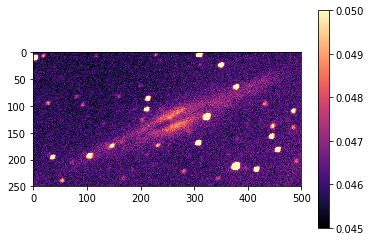

In [175]:
plot_galaxy_B()

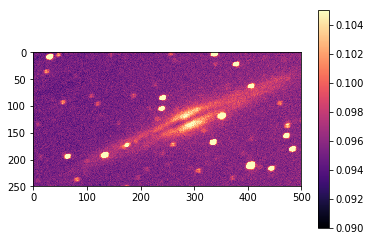

In [176]:
plot_galaxy_V()

In [177]:
cat_B = load_cat("data/B_gal.cat")
cat_B.sort_values(by="flux", ascending=False, inplace=True)

In [178]:
w_B = wcs.WCS(hduB.header)

In [179]:
starwcs_B = np.stack((cat_B["ra"], cat_B["dec"])).T

In [180]:
cat_V = load_cat("data/V_gal.cat")
cat_V.sort_values(by="flux", ascending=False, inplace=True)

w_V = wcs.WCS(hduV.header)

starwcs_V = np.stack((cat_B["ra"], cat_B["dec"])).T

In [181]:
starpix_B = w_B.wcs_world2pix(starwcs_B, 0)
starpix_V = w_V.wcs_world2pix(starwcs_V, 0)

In [182]:
indx_B = np.indices(imageB.shape)
pix_B = np.stack((indx_B[0].flatten(), indx_B[1].flatten())).T

indx_V = np.indices(imageV.shape)
pix_V = np.stack((indx_V[0].flatten(), indx_V[1].flatten())).T

In [183]:
for pair in starpix_B:
    
    dist_B = np.sqrt(((pix_B - pair)**2).sum(axis=1))
    inradius_B = pix_B[dist_B < 9.6].T
    imageB[inradius_B[0], inradius_B[1]] = 0.0
    
for pair in starpix_V:
    
    dist_V = np.sqrt(((pix_V - pair)**2).sum(axis=1))
    inradius_V = pix_V[dist_V < 9.6].T
    imageV[inradius_V[0], inradius_V[1]] = 0.0

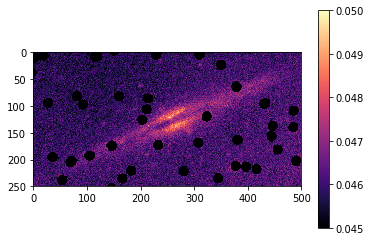

In [184]:
plot_galaxy_B()

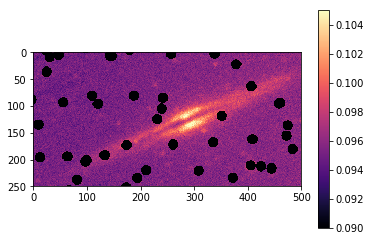

In [185]:
plot_galaxy_V()

In [186]:
def parx(t, x0, y0, a, b, theta):
    
    return a*np.cos(t)*np.cos(theta) - b*np.sin(t)*np.sin(theta) + x0

def pary(t, x0, y0, a, b, theta):
    
    return a*np.cos(t)*np.sin(theta) + b*np.sin(t)*np.cos(theta) + y0

def plot_ellipse(x0, y0, a, b, theta):
    
    t = np.linspace(0, 2*np.pi)
    x = parx(t, x0, y0, a, b, theta)
    y = pary(t, x0, y0, a, b, theta)
    plt.plot(x, y, color="deepskyblue")

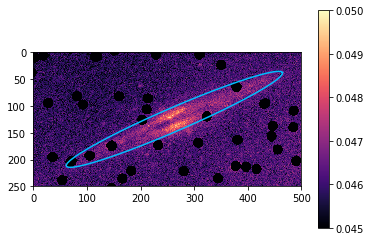

In [187]:
plot_galaxy_B()
x0_B, y0_B, a_B, b_B, theta_B = 263, 125, 220, 22, -0.13 * np.pi
plot_ellipse(x0_B, y0_B, a_B, b_B, theta_B)

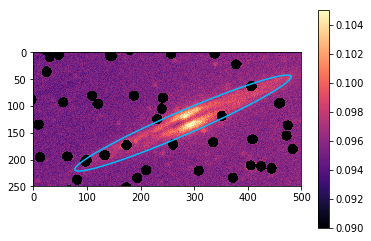

In [200]:
plot_galaxy_V()
x0_V, y0_V, a_V, b_V, theta_V = 279, 132, 220, 22, -0.13 * np.pi
plot_ellipse(x0_V, y0_V, a_V, b_V, theta_V)

In [201]:
def ABC(x0, y0, a, b, theta):
    
    A = (np.cos(theta)/a)**2 + (np.sin(theta)/b)**2
    B = 2*np.cos(theta)*np.sin(theta)*(1/a**2 - 1/b**2)
    C = (np.sin(theta)/a)**2 + (np.cos(theta)/b)**2
    
    return A,B,C

def x_y(y):
    
    y -= y0
    D = B*y
    E = C*y**2 - 1
    desc = D**2 - 4*A*E
    if desc < 0: return None
    x1 = (-D - np.sqrt(desc)) / A + x0
    x2 = (-D + np.sqrt(desc)) / A + x0
    return x1, x2

def y_x(x):
    
    x -= x0
    D = B*x
    E = A*x**2 - 1
    desc = D**2 - 4*C*E
    if desc < 0: return None
    y1 = (-D - np.sqrt(desc)) / C + y0
    y2 = (-D + np.sqrt(desc)) / C + y0
    return y1, y2

def inside_ellipse(x, y):
    
    inside = True
    
    try:
        x1, x2 = x_y(y)
        y1, y2 = y_x(x)
    except TypeError:
        return False
    
    inside &= x1 <= x <= x2
    inside &= y1 <= y <= y2
    return inside

In [189]:
for pair in pix_B[10000:12500]:
    
    if inside_ellipse(*pair):
        plt.plot(*pair, color="blue")
        
for pair in pix_V[10000:12500]:
    
    if inside_ellipse(*pair):
        plt.plot(*pair, color="blue")

In [190]:
y = pix_B.T[0].reshape(imageB.shape)[675:925, 325:825] - 675
y = y[::-1]

In [191]:
y

array([[249, 249, 249, ..., 249, 249, 249],
       [248, 248, 248, ..., 248, 248, 248],
       [247, 247, 247, ..., 247, 247, 247],
       ...,
       [  2,   2,   2, ...,   2,   2,   2],
       [  1,   1,   1, ...,   1,   1,   1],
       [  0,   0,   0, ...,   0,   0,   0]])